# Project 2

thoughts: using polar coordinates

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr
from scipy.signal import convolve2d
from util import spike_gen

In [2]:
# Load the image
image_path = "assets/image.jpg"
raw_image = Image.open(image_path)

raw_image.size, raw_image.mode
# raw_image

((7525, 5729), 'RGB')

resized image size: (752, 572)


Text(0.5, 1.0, 'image_array')

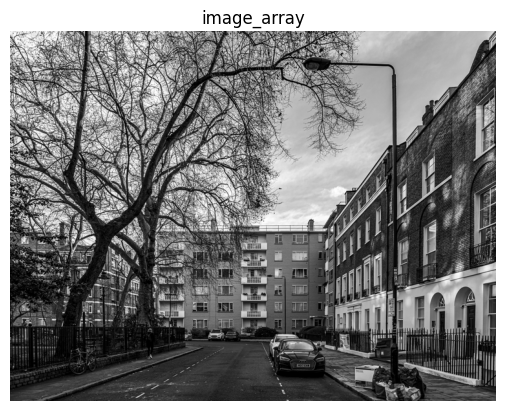

In [3]:
reduce_factor = 10

new_width = raw_image.width // reduce_factor
new_height = raw_image.height // reduce_factor

# Resize image using ANTIALIAS for better quality
resized_image = raw_image.resize((new_width, new_height), Image.LANCZOS)
print("resized image size:", resized_image.size)
image = resized_image.convert("L")
image_array = np.array(image, dtype=np.float32)
image_array /= 255.0 # Normalize to [0, 1]
plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.title("image_array")

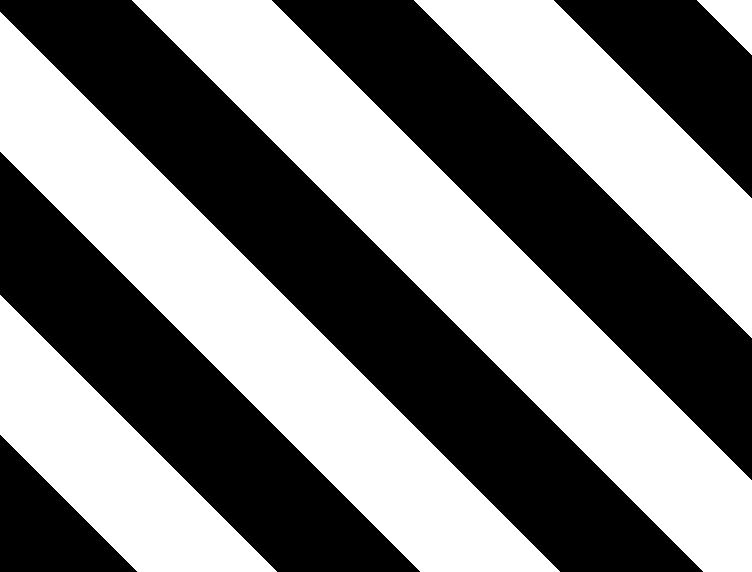

In [4]:
def create_grating(width=500, height=500, stripe_width=10, angle=0):
    """Create a black and white grating pattern image with a specified angle."""
    # Create a larger image to accommodate rotation
    diagonal = int(np.sqrt(width**2 + height**2))
    img = Image.new("L", (diagonal, diagonal), "white")
    draw = ImageDraw.Draw(img)

    # Draw parallel black stripes
    for x in range(0, diagonal, stripe_width * 2):
        draw.rectangle([(x, 0), (x + stripe_width, diagonal)], fill="black")

    # Rotate image
    img = img.rotate(angle, expand=True)

    # Crop to center with the original width and height
    left = (img.width - width) // 2
    top = (img.height - height) // 2
    img = img.crop((left, top, left + width, top + height))

    # Show and save the result
    return img

image_array = create_grating(width=752, height=572, stripe_width=100, angle=45)
image_array


## Gabor Function

$$
D_s(x, y) = \frac{1}{2\pi\sigma_x\sigma_y} \exp\left( -\frac{x^2}{2\sigma_x^2} - \frac{y^2}{2\sigma_y^2} \right) \cos(kx - \phi).
$$

The parameters in this function determine the properties of the spatial receptive field: 
$\sigma_x$ and $\sigma_y$ determine its extent in the $x$ and $y$ directions, respectively;
$k$, the preferred spatial frequency, determines the spacing of light and dark bars that produce the maximum response 
(the preferred spatial wavelength is $2\pi/k$); and $\phi$ is the preferred spatial phase, which determines 
where the ON-OFF boundaries fall within the receptive field.


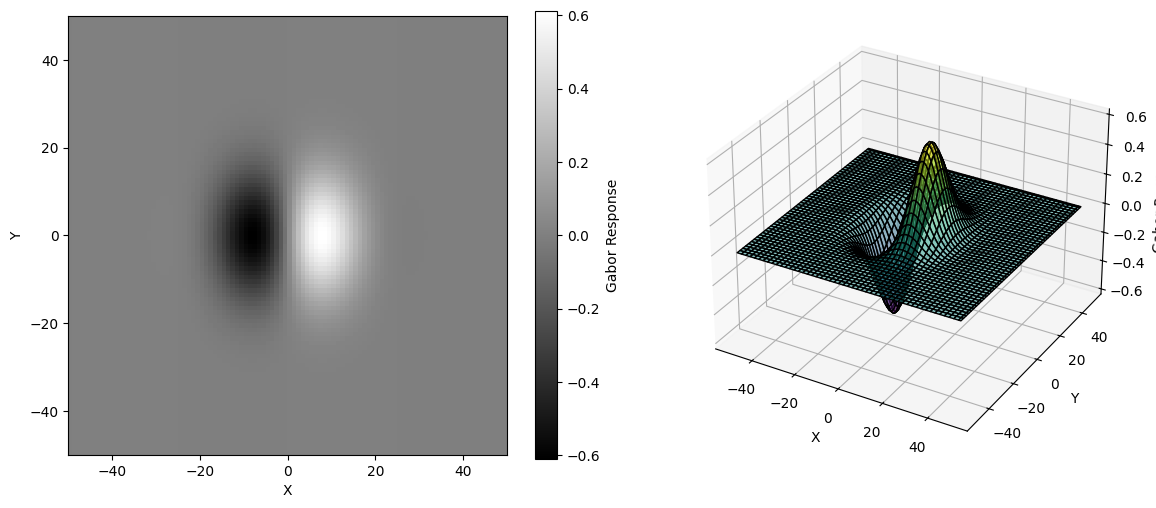

In [5]:
def gabor_function(x, y, wavelength, orientation, phase, sigma_x, sigma_y):
    # Rotate coordinates
    x_theta = x * np.cos(orientation) + y * np.sin(orientation)
    y_theta = -x * np.sin(orientation) + y * np.cos(orientation)
    # Gaussian Envelope
    gaussian_envelope = np.exp(-(x_theta**2 / (2 * sigma_x**2) + y_theta**2 / (2 * sigma_y**2)))
    # Sinusoidal plane wave
    sinusoid = np.cos(2 * np.pi * x_theta / wavelength + phase)
    return gaussian_envelope * sinusoid

neuron_size = 100 # wavelength of the Gabor filter
wavelength = neuron_size / 2
orientation = np.pi
phase = np.pi / 2
sigma_x = wavelength/5 # arbitrary choice
sigma_y = wavelength/5 # arbitrary choice

x = np.linspace(-wavelength, wavelength, neuron_size)
y = np.linspace(-wavelength, wavelength, neuron_size)
X, Y = np.meshgrid(x, y)

gabor = gabor_function(X, Y, wavelength, orientation, phase, sigma_x, sigma_y)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
im = ax1.imshow(gabor, cmap='gray', extent=[-wavelength, wavelength, -wavelength, wavelength])
fig.colorbar(im, ax=ax1, label="Gabor Response")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

# 3D Plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d', elev=30, azim=-60)
ax2.plot_surface(X, Y, gabor, cmap='viridis', edgecolor='k', alpha=0.5)
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Gabor Response")

# Show plots
plt.tight_layout()


## Estimating Firing Rate

$$
r_{est} = r_0 + F(L(t))
$$

assuming Linear Estimate and a separable temporal factor, we have

$$
F(L(t)) = L_s = \int dxdy \, D(x,y) s(x,y).
$$

where $L_s$ is the spatial linear estimate of the firing rate of a single neuron, $D(x,y)$ is the Gabor function, and $s(x,y)$ is the stimulus.

In [6]:
def estimate_response(
    image_array: np.ndarray, 
    gabor: np.ndarray, 
    neuron_size: int,
    neuron_center: tuple,
    plot: bool = False,
    ) -> float:
    y_center, x_center = neuron_center

    # Create a zero-padded array of the expected neuron size
    neuron_img_arr = np.zeros((neuron_size, neuron_size), dtype=image_array.dtype)
    
    # Define the expected boundaries in the image
    y_start_img = max(0, y_center - neuron_size // 2)
    y_end_img   = min(image_array.shape[0], y_center + neuron_size // 2)
    x_start_img = max(0, x_center - neuron_size // 2)
    x_end_img   = min(image_array.shape[1], x_center + neuron_size // 2)
    
    # Calculate the corresponding indices in the zero-padded neuron image
    offset_y = y_start_img - (y_center - neuron_size // 2)
    offset_x = x_start_img - (x_center - neuron_size // 2)
    
    neuron_img_arr[offset_y:offset_y + (y_end_img - y_start_img),
                   offset_x:offset_x + (x_end_img - x_start_img)] = image_array[y_start_img:y_end_img,
                                                                               x_start_img:x_end_img]
    r_est = np.sum(gabor * neuron_img_arr)
    
    if plot:
        # Create an overlay on the full image
        overlay = np.zeros_like(image_array)
        # Only update the region that overlaps with the image
        overlay[y_start_img:y_end_img, x_start_img:x_end_img] = gabor[offset_y:offset_y+(y_end_img - y_start_img),
                                                                      offset_x:offset_x+(x_end_img - x_start_img)]
        alpha = 0.5  # (0 = only image, 1 = only Gabor)
        overlayed_image = (1 - alpha) * image_array + alpha * overlay
        
        plt.figure(figsize=(6, 6))
        plt.imshow(overlayed_image, cmap="gray")
        plt.title("Gabor Function Overlayed on Full Image")
        plt.axis("off")
        plt.show()
    return r_est

neuron_center = (500,500)
r_est = estimate_response(image_array, gabor, neuron_size, neuron_center, plot=True)
r_est

AttributeError: 'Image' object has no attribute 'dtype'

## Encoding

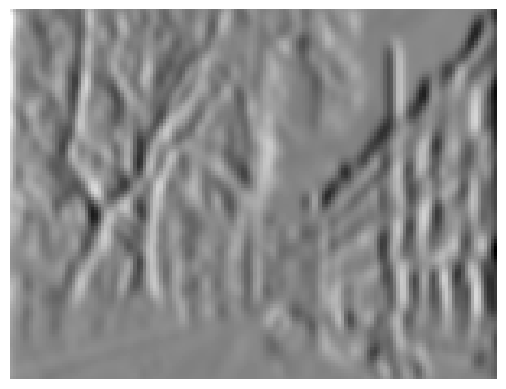

In [ ]:
def encode(
    image_array: np.ndarray, 
    gabor: np.ndarray, 
    neuron_size: int,
    num_neurons: tuple[int, int],
    plot: bool = False,
    ) -> np.ndarray:

    r_est_array = np.zeros((n, m), dtype=np.float32)
    for i in range(1,n+1):
        for j in range(1,m+1):
            x_center = image_array.shape[0] // n * i
            y_center = image_array.shape[1] // m * j
            neuron_center = (x_center, y_center)
            r_est_array[i-1, j-1] = estimate_response(
                image_array, gabor, neuron_size, neuron_center, plot=False
            )
    r_est_array.max(), r_est_array.min()

    r_est_array /= max(r_est_array.max(), abs(r_est_array.min()))
    
    if plot:
        plt.imshow(r_est_array, cmap="gray")
        plt.axis("off")
    return r_est_array

n = image_array.shape[0] // 5
m = image_array.shape[1] // 5
r_est_array = encode(image_array, gabor, neuron_size, (n, m), plot=True)

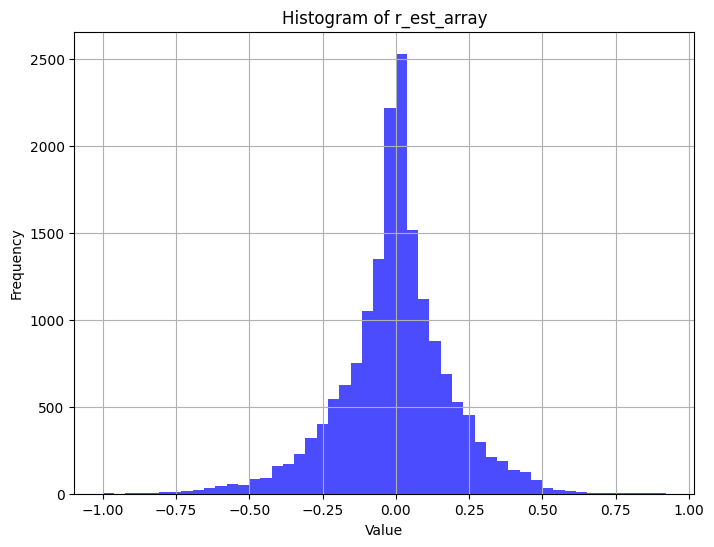

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(r_est_array.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Histogram of r_est_array")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

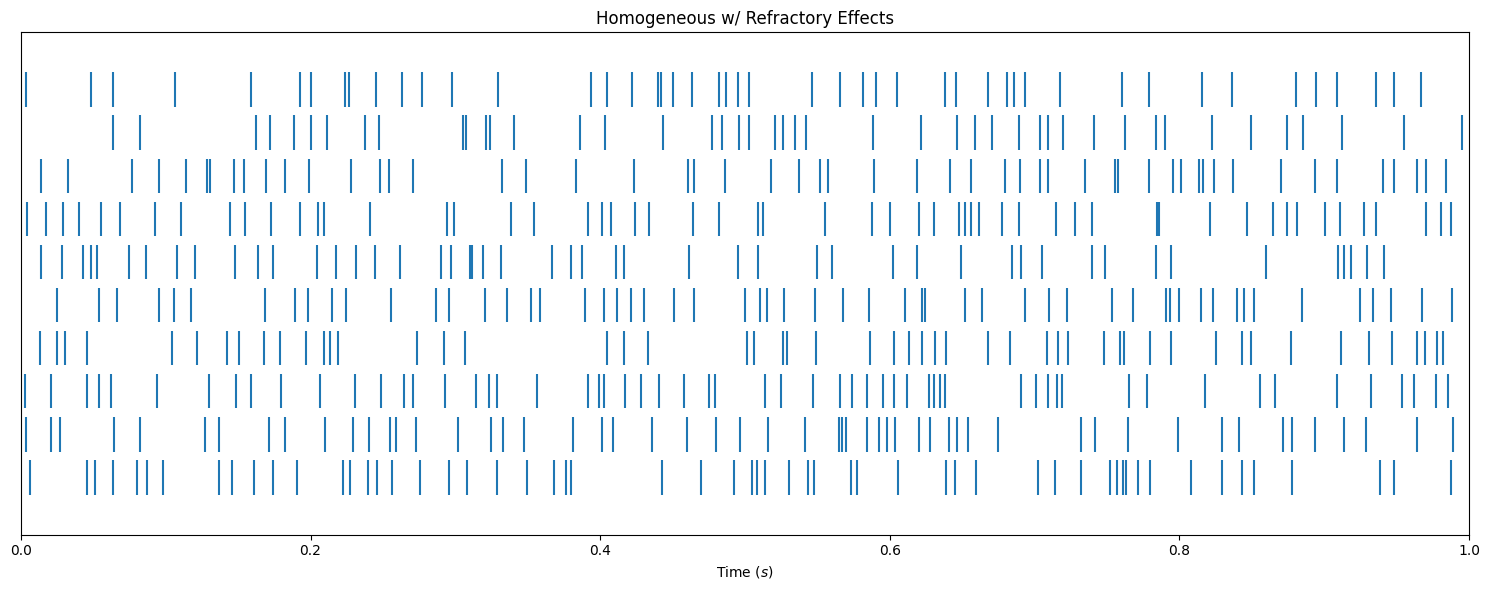

In [ ]:
r_est_array_scaled = ((r_est_array + 2) / 2) * 120
T = 1 # [s]

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
neuron_response = []
for r in r_est_array_scaled.flatten():
    neuron_response.append(spike_gen.fast_spike_generator(r, T=T)["Homogeneous w/ Refractory Effects"])

ax.set_xlim(0, T)
ax.set_title("Homogeneous w/ Refractory Effects")
ax.set_xlabel("Time ($s$)")
ax.get_yaxis().set_visible(False)
ax.eventplot(neuron_response[:10], linelengths=0.8)
fig.tight_layout()

## Decoding

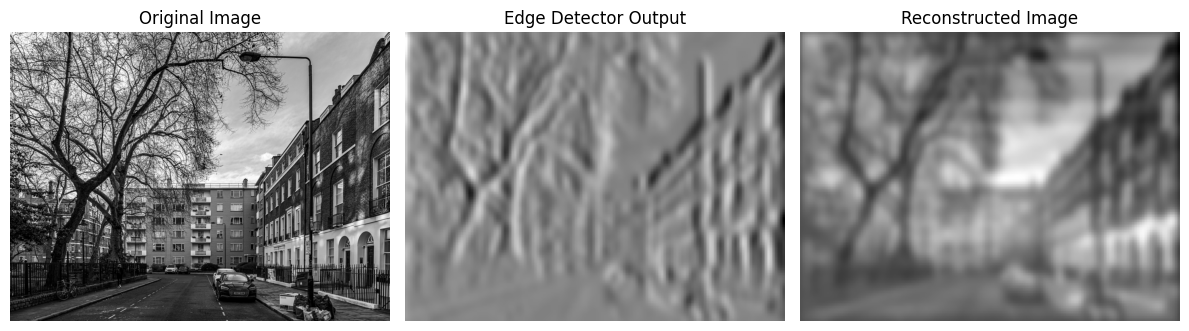

(np.float32(-1.0),
 np.float32(0.9219679),
 np.float32(-1.6409639),
 np.float32(3.888905))

In [ ]:
def decode(
    neural_resp_arr: np.ndarray
    ) -> np.ndarray:
    decoded = np.cumsum(neural_resp_arr, axis=1)
    return decoded

# decoded = np.cumsum(r_est_array.transpose(), axis=0)
decoded_array = decode(r_est_array)

# Plot the images for comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Edge Detector Output")
plt.imshow(r_est_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(decoded_array, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
r_est_array.min(), r_est_array.max(), decoded_array.min(), decoded_array.max()

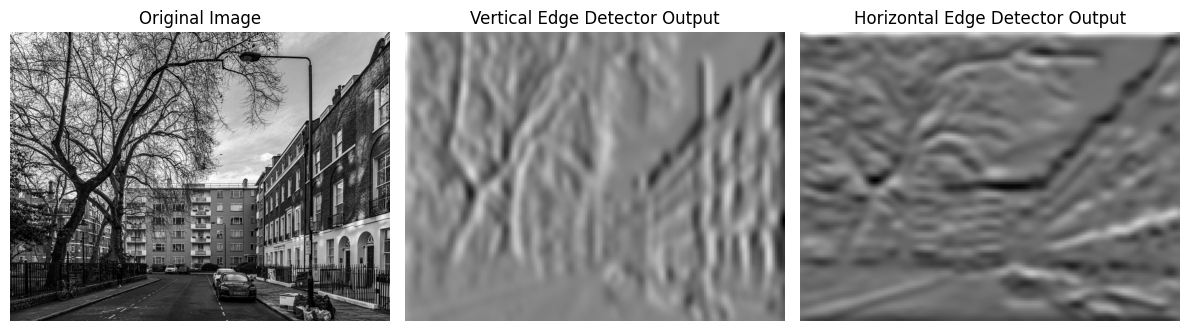

In [ ]:
# Define Gabor filters for vertical and horizontal edge detection
vertical_orientation = np.pi           # Vertical edge detector (sensitive to vertical edges)
horizontal_orientation = -np.pi / 2   # Horizontal edge detector (sensitive to horizontal edges)

# Create two Gabor filters with different orientations
gabor_vertical = gabor_function(X, Y, wavelength, vertical_orientation, phase, sigma_x, sigma_y)
gabor_horizontal = gabor_function(X, Y, wavelength, horizontal_orientation, phase, sigma_x, sigma_y)

# Encode the image using each filter
r_est_array_vertical = encode(image_array, gabor_vertical, neuron_size, (n, m), plot=False)
r_est_array_horizontal = encode(image_array, gabor_horizontal, neuron_size, (n, m), plot=False)

# Plot the images for comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Vertical Edge Detector Output")
plt.imshow(r_est_array_vertical, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Horizontal Edge Detector Output")
plt.imshow(r_est_array_horizontal, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

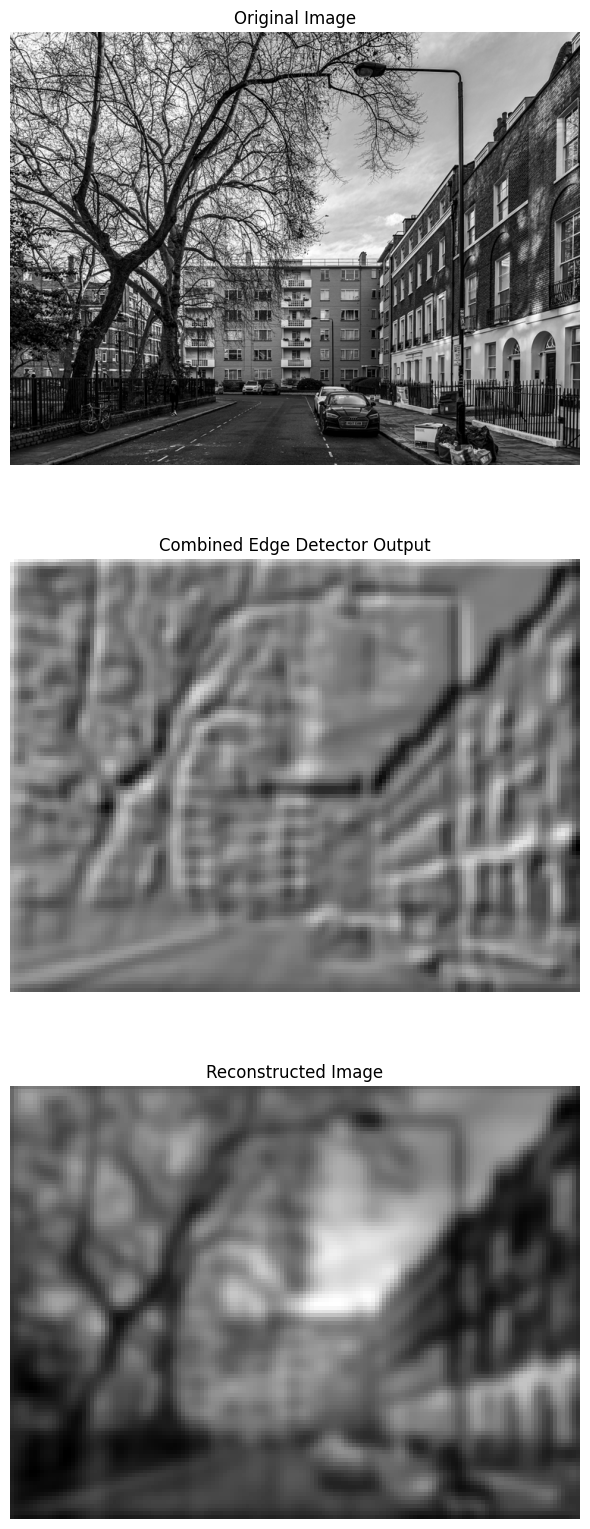

In [ ]:
def decode_edges(r_est_array_vertical: np.ndarray, r_est_array_horizontal: np.ndarray) -> np.ndarray:
    """
    Decodes the image by integrating the vertical and horizontal edge responses.
    
    Parameters:
    - r_est_array_vertical: 2D array from the vertical edge detector (approximates horizontal gradient)
    - r_est_array_horizontal: 2D array from the horizontal edge detector (approximates vertical gradient)
    
    Returns:
    - reconstructed: The decoded image after integrating both gradients.
    """
    # Integrate the vertical edge responses along the horizontal direction (axis=1)
    # This approximates reconstructing the image by integrating the horizontal gradient.
    recon_from_vertical = np.cumsum(r_est_array_vertical, axis=1)
    
    # Integrate the horizontal edge responses along the vertical direction (axis=0)
    # This approximates reconstructing the image by integrating the vertical gradient.
    recon_from_horizontal = np.cumsum(r_est_array_horizontal, axis=0)
    
    # Combine the two integrated images.
    # A simple approach is to average them, though other weighted combinations might be considered.
    reconstructed = (recon_from_vertical + recon_from_horizontal) / 2
    
    return reconstructed

decoded_array = decode_edges(r_est_array_vertical, r_est_array_horizontal)

plt.figure(figsize=(6, 16))
plt.subplot(3, 1, 1)
plt.title("Original Image")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.title("Combined Edge Detector Output")
# For visualization
combined_response = (r_est_array_vertical + r_est_array_horizontal) / 2
plt.imshow(combined_response, cmap='gray')
plt.axis('off')

plt.subplot(3, 1, 3)
plt.title("Reconstructed Image")
plt.imshow(decoded_array, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


multiscale and multi orientation in an iterative manner such that it uses large neurons at few orientations then using information from this encoded information, encode more detailed information. e.g. if the standard deviation of responses from large neurons next to each other 

## Analysis

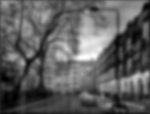

In [ ]:
def normalize_to_255(image: np.ndarray) -> np.ndarray:
    # Ensure the image is a float for accurate normalization
    image = image.astype(np.float32)
    
    # Normalize to range 0-1
    image_min = image.min()
    image_max = image.max()
    if image_max - image_min == 0:
        return np.zeros_like(image, dtype=np.uint8)
    
    normalized = (image - image_min) / (image_max - image_min)
    
    # Scale to range 0-255 and convert to uint8
    normalized_255 = (normalized * 255).astype(np.uint8)
    
    return normalized_255
decoded_normalized = normalize_to_255(decoded_array)

decoded_image = Image.fromarray(decoded_normalized, mode='L')
decoded_image

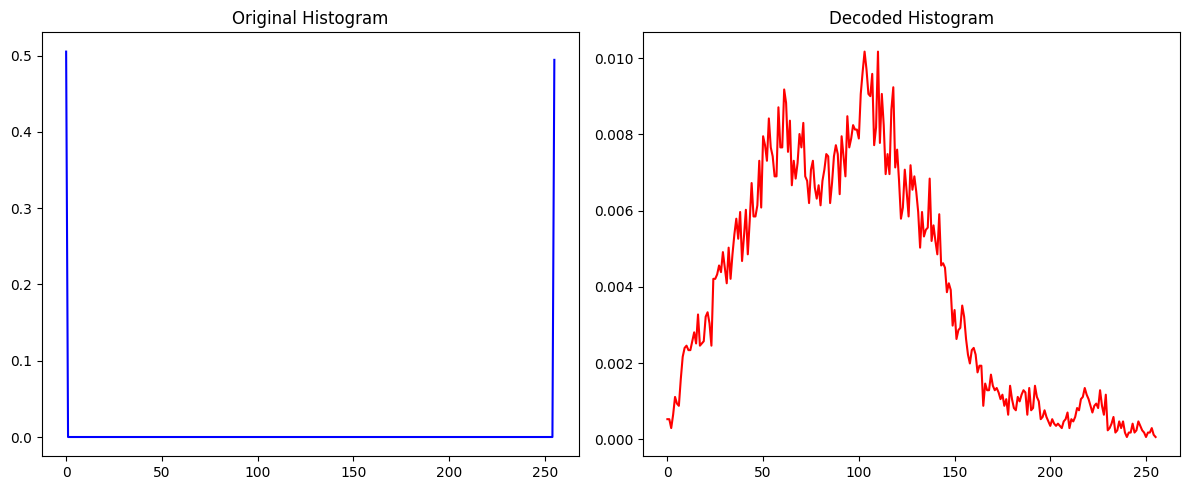

Relative Entropy: 7.943241167616186


In [ ]:
image_histogram = np.array(image.histogram())
decoded_histogram = np.array(decoded_image.histogram())

image_histogram = image_histogram / image_histogram.sum()
decoded_histogram = decoded_histogram / decoded_histogram.sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(image_histogram, color='blue', label='Original Histogram')
ax[0].set_title('Original Histogram')
ax[1].plot(decoded_histogram, color='red', label='Decoded Histogram')
ax[1].set_title('Decoded Histogram')
plt.tight_layout()
plt.show()

# Compute KL divergence
rel_entropy = np.sum(rel_entr(image_histogram, decoded_histogram))  # rel_entr = P * log(P/Q)

print(f"Relative Entropy: {rel_entropy}")


In [ ]:
# def create_gabor_filter(wavelength, orientation, phase, sigma_x, sigma_y):
#     # Define the filter size to be proportional to the wavelength (to capture enough cycles)
#     filter_size = int(2 * wavelength)
#     x = np.linspace(-wavelength, wavelength, filter_size)
#     y = np.linspace(-wavelength, wavelength, filter_size)
#     X, Y = np.meshgrid(x, y)
#     return gabor_function(X, Y, wavelength, orientation, phase, sigma_x, sigma_y)

# # Define parameters for the filter bank:
# orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0°, 45°, 90°, 135°
# scales = [50, 100, 150]  # Example wavelengths for different scales
# phase = np.pi/2  # Phase offset (you can experiment with this)

# # Create and apply the filter bank
# responses = {}  # Dictionary to store responses for each (scale, orientation)
# for wavelength in scales:
#     # Define sigma values relative to wavelength (adjust as needed)
#     sigma_x = wavelength / 5
#     sigma_y = wavelength / 5
#     for orientation in orientations:
#         # Create the Gabor filter for this scale and orientation
#         gabor_filter = create_gabor_filter(wavelength, orientation, phase, sigma_x, sigma_y)
#         # Convolve the filter with the image (using 'same' mode to keep dimensions)
#         response = convolve2d(image_array, gabor_filter, mode='same', boundary='wrap')
#         responses[(wavelength, orientation)] = response

# # For visualization, let's plot a few filter responses:
# fig, axs = plt.subplots(len(scales), len(orientations), figsize=(12, 8))
# for i, wavelength in enumerate(scales):
#     for j, orientation in enumerate(orientations):
#         response = responses[(wavelength, orientation)]
#         axs[i, j].imshow(response, cmap='gray')
#         axs[i, j].set_title(f"Scale: {wavelength}, Ori: {np.degrees(orientation):.0f}°")
#         axs[i, j].axis("off")
# plt.tight_layout()
# plt.show()



KeyboardInterrupt: 